# Prueba de 3 modelos de Lenguaje Natural

### Integrantes

1. Cesar Avellaneda, 202214746, c.avellanedac@uniandes.edu.co.
2. Santiago Tinjaca, 202215991, s.tinjaca@uniandes.edu.co.
3. Jorge Bustamante,

Y contiene los siguientes elementos:
1. Cargue de los datos.

2. Entendimiento de los datos: Describir las características más relevantes de los datos y todo el perfilamiento de datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.

3. Preparación de datos: Solucionar los problemas de calidad de datos previamente identificados que afecten el modelo a construir. Además, debe aplicar todos los proceso de preprocesamiento de datos necesarios para la construcción del modelo de regresión.

4. Modelado: Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.


# Entendimiento del Problema:

El problema principal radica en la necesidad de analizar de forma eficiente y automática grandes volúmenes de opiniones en lenguaje natural para relacionarlas con los ODS 3 (Salud y Bienestar), 4 (Educación de Calidad) y 5 (Igualdad de Género). Actualmente, este proceso es manual y requiere la intervención de expertos, lo que lo hace costoso y lento. La oportunidad consiste en desarrollar un modelo analítico automatizado que reduzca el tiempo y los recursos necesarios para este análisis, permitiendo una respuesta más rápida y efectiva a las necesidades de los ciudadanos.

# Enfoque Analitico:

Categoría de Análisis:
El análisis será predictivo y descriptivo. Descriptivo en el sentido de identificar y categorizar opiniones actuales, y predictivo al inferir tendencias y futuras necesidades o áreas de intervención.

Tipo y Tarea de Aprendizaje:
Aprendizaje Supervisado: Para clasificar las opiniones y relacionarlas con los ODS.


# 1. Carga de los Datos:

In [8]:
import inflect
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import sys
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import spacy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
entrevistasODS = pd.read_excel('./data/ODScat_345.xlsx')

# 2. Perfilamiento y entendimiento de datos:

Se puede ver que los datos recibidos se cuentan con 4049 registro con 2 columnas, el texto en español que corresponde a la opinion de las personas y el SDG indica a cual corresponde.

In [10]:
print(entrevistasODS.head())

                                      Textos_espanol  sdg
0  Por ejemplo, el nÃºmero de consultas externas ...    3
1  En 2007, el gobierno central financió directam...    3
2  Claramente, hay muchos otros factores en juego...    3
3  Por ejemplo, el estado australiano de Victoria...    3
4  El consumo anual de alcohol se estima en 15,7 ...    3


In [11]:
entrevistasODS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


En el analisis de cada linea tiene en promedio 699 caractes, cada palabra maximo tiene 83 caracteres.

In [12]:
entrevistadosCopy = entrevistasODS.copy()
entrevistadosCopy['Conteo'] = [len(x) for x in entrevistadosCopy['Textos_espanol']]
entrevistadosCopy['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in entrevistadosCopy['Textos_espanol']]
entrevistadosCopy['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in entrevistadosCopy['Textos_espanol']]
entrevistadosCopy.describe()

,sdg,Conteo,Max,Min
count,4049.000000,4049.000000,4049.000000,4049.000000
mean,4.051124,699.632502,15.305508,0.967399
std,0.814338,228.988965,3.888995,0.208335
min,3.000000,294.000000,9.000000,0.000000
25%,3.000000,531.000000,14.000000,1.000000
50%,4.000000,657.000000,15.000000,1.000000
75%,5.000000,827.000000,16.000000,1.000000
max,5.000000,1513.000000,83.000000,2.000000


# 3. Limpieza de Datos:

Definicmos las trasformaciones que se le harán a cada palabra, convertirlas en ascii, ponerlas en minuscula, eliminar puntuación.

In [13]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words=[]
    for word in words:
        w= word.lower()
        new_words.append(w)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()    
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    spanish_sw = set(stopwords.words('spanish'))
    new_words = []
    for word in words:
        if word not in spanish_sw:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [14]:
entrevistasODS['palabras'] = entrevistasODS['Textos_espanol'].apply(word_tokenize)
entrevistasODS.head()

,Textos_espanol,sdg,palabras
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."


In [15]:
entrevistasODS['palabras'].dropna()

0       [Por, ejemplo, ,, el, nÃºmero, de, consultas, ...
1       [En, 2007, ,, el, gobierno, central, financió,...
2       [Claramente, ,, hay, muchos, otros, factores, ...
3       [Por, ejemplo, ,, el, estado, australiano, de,...
4       [El, consumo, anual, de, alcohol, se, estima, ...
                              ...                        
4044    [Para, ello, ,, identificará, las, cuestiones,...
4045    [La, participación, de, las, mujeres, en, role...
4046    [Según, el, WEF, ,, según, las, tendencias, de...
4047    [Sirve, como, recurso, y, foro, para, las, age...
4048    [Las, áreas, útiles, para, un, mayor, estudio,...
Name: palabras, Length: 4049, dtype: object

In [16]:
entrevistasODS['palabras'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4049 entries, 0 to 4048
Series name: palabras
Non-Null Count  Dtype 
--------------  ----- 
4049 non-null   object
dtypes: object(1)
memory usage: 31.8+ KB


Aplicamos las trasformaciones a cada uno de los registros para limpiar las palabras.

In [17]:
entrevistasODS['palabras1']=entrevistasODS['palabras'].apply(preprocessing)
entrevistasODS.head()

,Textos_espanol,sdg,palabras,palabras1
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[ejemplo, naomero, consultas, externas, especi..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[two thousand and seven, gobierno, central, fi..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, australiano, victoria, creo, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consumo, anual, alcohol, estima, 157, litros,..."


# Normalizar

In [18]:
nlp = spacy.load("es_core_news_sm")

stemmer = SnowballStemmer('spanish')

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmas = []
    for word in words:
        doc = nlp(word)
        for token in doc:
            if token.pos_ == 'VERB':
                lemmas.append(token.lemma_)
            else:
                lemmas.append(word)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    # lemmas = lemmatize_verbs(words)
    return stems

entrevistasODS['palabras1'] = entrevistasODS['palabras1'].apply(stem_and_lemmatize)
entrevistasODS.head()


,Textos_espanol,sdg,palabras,palabras1
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[ejempl, naomer, consult, extern, especial, th..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[two thousand and sev, gobiern, central, finan..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[clar, factor, jueg, particul, varied, barrer,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejempl, australian, victori, cre, agenci, pro..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consum, anual, alcohol, estim, 157, litr, ano..."


In [19]:
entrevistasODS['palabras'] = entrevistasODS['palabras1'].apply(lambda x: ' '.join(map(str, x)))
entrevistasODS

,Textos_espanol,sdg,palabras,palabras1
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,ejempl naomer consult extern especial three hu...,"[ejempl, naomer, consult, extern, especial, th..."
1,"En 2007, el gobierno central financió directam...",3,two thousand and sev gobiern central financi d...,"[two thousand and sev, gobiern, central, finan..."
2,"Claramente, hay muchos otros factores en juego...",3,clar factor jueg particul varied barrer determ...,"[clar, factor, jueg, particul, varied, barrer,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,ejempl australian victori cre agenci promocion...,"[ejempl, australian, victori, cre, agenci, pro..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,consum anual alcohol estim 157 litr ano hombr ...,"[consum, anual, alcohol, estim, 157, litr, ano..."
...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,ello identific cuestion gener mas destac malt ...,"[ello, identific, cuestion, gener, mas, destac..."
4045,La participación de las mujeres en roles de li...,5,particip mujer rol liderazg dentr legislatur t...,"[particip, mujer, rol, liderazg, dentr, legisl..."
4046,"Según el WEF, según las tendencias de 2016, po...",5,segun wef segun tendenci two thousand and sixt...,"[segun, wef, segun, tendenci, two thousand and..."
4047,"Sirve como recurso y foro para las agencias, c...",5,sirv recurs for agenci objet logr enfoqu integ...,"[sirv, recurs, for, agenci, objet, logr, enfoq..."


In [20]:
X_data, y_data = entrevistasODS['palabras'],entrevistasODS['sdg']
y_data

0       3
1       3
2       3
3       3
4       3
       ..
4044    5
4045    5
4046    5
4047    5
4048    5
Name: sdg, Length: 4049, dtype: int64

In [21]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_dense = X_count.toarray()
X_df = pd.DataFrame(X_dense, columns=count.get_feature_names_out())

(4049, 11793)


# SMV

              precision    recall  f1-score   support

           3       0.97      0.98      0.98       372
           4       0.97      0.97      0.97       402
           5       0.98      0.98      0.98       441

    accuracy                           0.97      1215
   macro avg       0.97      0.97      0.97      1215
weighted avg       0.97      0.97      0.97      1215



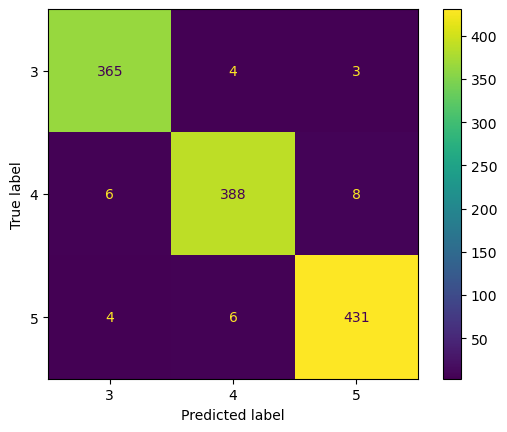

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_data, test_size=0.3, random_state=42)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [23]:
coef = svm_model.coef_

feature_names = svm_model.feature_names_in_  
classes_n = svm_model.classes_
classes = [(3,4),(3,5),(4,5)]

word_importance = {class_label: np.zeros(len(feature_names)) for class_label in classes_n}

n_classifiers = coef.shape[0]

for i in range(n_classifiers):
    class_pair = classes[i]

    word_importance[class_pair[0]] += coef[i]
    word_importance[class_pair[1]] += -coef[i] 

for class_label, importance in word_importance.items():
    top_indices = np.argsort(importance)[-10:] 
    top_words = [feature_names[index] for index in top_indices]
    
    print(f"Clase: {class_label}")
    print("Palabras más importantes:", top_words)
    print("Coeficientes:", importance[top_indices])
    print()

Clase: 3
Palabras más importantes: ['consum', 'medicament', 'tratamient', 'atencion', 'medic', 'enfermedad', 'drog', 'pacient', 'sanitari', 'salud']
Coeficientes: [0.31863243 0.37243145 0.37918912 0.38311976 0.39009665 0.40662805
 0.41165145 0.42367793 0.53330036 0.71438411]

Clase: 4
Palabras más importantes: ['habil', 'maestr', 'alumn', 'ensen', 'profesor', 'docent', 'aprendizaj', 'escuel', 'estudi', 'educ']
Coeficientes: [0.30623457 0.31309484 0.31377747 0.32924402 0.39674029 0.41964844
 0.42597697 0.49804123 0.57013052 0.70402263]

Clase: 5
Palabras más importantes: ['derech', 'adolescent', 'iguald', 'chic', 'sexual', 'sex', 'femenin', 'muj', 'gener', 'mujer']
Coeficientes: [0.3493632  0.36156659 0.36793145 0.37131466 0.40510718 0.42990193
 0.43166086 0.65655414 0.97123908 1.03733064]



# Bolsa de Palabras

In [24]:
X_data, y_data = entrevistasODS['palabras'],entrevistasODS['sdg']


In [25]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data) 
print(X_dummy.shape)

X_dense = X_dummy.toarray()
X_df = pd.DataFrame(X_dense, columns=dummy.get_feature_names_out())
X_df


(4049, 11793)


,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(X_dummy)


In [27]:
tt_matrix_dense = tt_matrix.toarray()
vocab = dummy.get_feature_names_out()
tt_df = pd.DataFrame(np.round(tt_matrix_dense, 2), columns=vocab)
tt_df


,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
import scipy.sparse as sp
feature_names = list(tt_df.columns)
# build the document frequency matrix
df = np.diff(sp.csc_matrix(tt_df, copy=True).indptr)
df = 1 + df # adding 1 to smoothen idf later
# show smoothened document frequencies
pd.DataFrame([df], columns=feature_names)

,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,2,4,2,2,2,2,2,7,2,3,...,2,2,2,2,96,2,2,2,2,2


In [29]:

# compute inverse document frequencies
total_docs = 1 + len(vocab)
idf = 1.0 + np.log(float(total_docs) / df)
# show smoothened idfs
pd.DataFrame([np.round(idf, 2)], columns=feature_names)

,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,9.68,8.99,9.68,9.68,9.68,9.68,9.68,8.43,9.68,9.28,...,9.68,9.68,9.68,9.68,5.81,9.68,9.68,9.68,9.68,9.68


In [30]:
# compute idf diagonal matrix
total_features = tt_df.shape[1]
idf_diag = sp.spdiags(idf, diags=0, m=total_features, n=total_features)
idf_dense = idf_diag.todense()
# print the idf diagonal matrix
pd.DataFrame(np.round(idf_dense, 2))

,0,1,2,3,4,5,6,7,8,9,...,11783,11784,11785,11786,11787,11788,11789,11790,11791,11792
0,9.68,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
1,0.00,8.99,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,9.68,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,9.68,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,9.68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11788,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.68,0.00,0.00,0.00,0.00
11789,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,9.68,0.00,0.00,0.00
11790,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,9.68,0.00,0.00
11791,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,9.68,0.00


In [31]:
# compute tfidf feature matrix
tf = np.array(tt_df, dtype="float64")
tfidf = tf * idf
# view raw tfidf feature matrix
tfidf = pd.DataFrame(np.round(tfidf, 2), columns=feature_names)
tfidf


,001,003,004,005,006,007,009,01,015,016,...,zogl,zoles,zoll,zomb,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, y_data, test_size=0.3, random_state=42)

In [33]:
from sklearn.naive_bayes import MultinomialNB

# Entrenamos el clasificador Naive Bayes con la matriz TF-IDF
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

Precisión: 0.94
              precision    recall  f1-score   support

           3       0.96      0.92      0.94       372
           4       0.91      0.96      0.93       402
           5       0.95      0.94      0.95       441

    accuracy                           0.94      1215
   macro avg       0.94      0.94      0.94      1215
weighted avg       0.94      0.94      0.94      1215



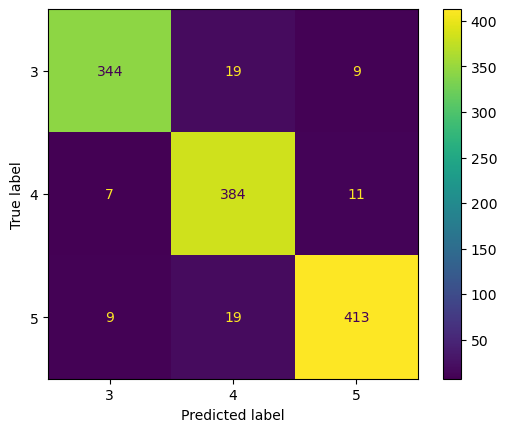

In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Hacemos predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calculamos la precisión
print(f"Precisión: {accuracy_score(y_test, y_pred):.2f}")

# Mostramos el reporte de clasificación
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Árbol de clasificación

In [35]:
from sklearn.tree import DecisionTreeClassifier


# Entrenamos el clasificador Decision Tree con la matriz TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(entrevistasODS['palabras'])
Y=entrevistasODS['sdg']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
clf = DecisionTreeClassifier()

In [36]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
y_pred = clf.predict(X_test) 

In [38]:
cm = confusion_matrix(y_test, y_pred)

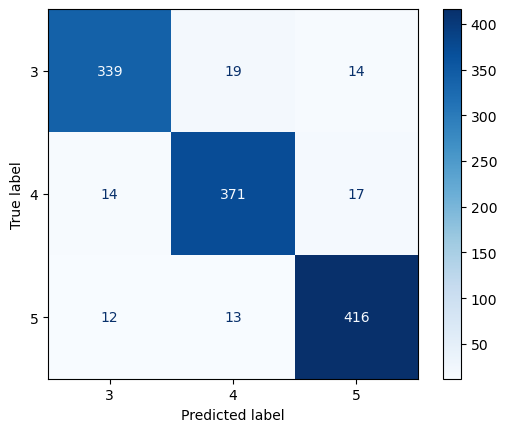

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score


print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred, average='weighted')))
print("Precisión: {}".format(precision_score(y_test,y_pred, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred, average='weighted')))

Exactitud: 0.93
Recall: 0.9267489711934156
Precisión: 0.9267464047012883
Puntuación F1: 0.9267062795594051


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.93      0.91      0.92       372
           4       0.92      0.92      0.92       402
           5       0.93      0.94      0.94       441

    accuracy                           0.93      1215
   macro avg       0.93      0.93      0.93      1215
weighted avg       0.93      0.93      0.93      1215

